<a href="https://colab.research.google.com/github/sellerstx1982/multimodal_damage_identification/blob/Sellers/project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from pathlib import Path
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, classification_report
from PIL import Image, ImageFile
import os
import matplotlib.pyplot as plt
import zipfile
import pickle
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load the data from pkl files
def load_data_from_pkl(pkl_filename):
    with open(pkl_filename, 'rb') as f:
        df = pickle.load(f)
    return df

df = load_data_from_pkl('/content/drive/MyDrive/Colab_Notebooks/Project_03/disaster_data.pkl')

# Preprocessing

In [ ]:
# ImageFile.LOAD_TRUNCATED_IMAGES = True
# main_folder = "/content/drive/MyDrive/Colab_Notebooks/Project_03/multimodal+damage+identification+for+humanitarian+computing/multimodal/"

In [ ]:
# # Lists to store the data
# images = []
# texts = []
# labels = []

# # Preprocessing function for images
# def preprocess_image(image_path):
#     try:
#         image = Image.open(image_path)
#         image = image.resize((250, 250))  # Example size, adjust accordingly
#         image = np.array(image) / 255.0  # Normalize pixel values
#         return np.expand_dims(image, axis=0)  # Add batch dimension
#     except Exception as e:
#         print(f"Error processing image {image_path}: {e}")
#         return None

# # Function to load text from a file
# def load_text_file(text_path):
#     try:
#         with open(text_path, 'r', encoding='utf-8') as file:
#             return file.read()
#     except Exception as e:
#         print(f"Error reading text file {text_path}: {e}")
#         return None

In [ ]:
# # Iterate over each category subfolder in the main folder
# for subfolder in os.listdir(main_folder):
#     subfolder_path = os.path.join(main_folder, subfolder)
#     if os.path.isdir(subfolder_path):
#         # The image and text folders inside each category folder
#         image_folder = os.path.join(subfolder_path, 'images')
#         text_folder = os.path.join(subfolder_path, 'text')

#         # Check if both the image and text folders exist
#         if os.path.exists(image_folder) and os.path.exists(text_folder):
#             for image_file in os.listdir(image_folder):
#                 if image_file.endswith(('jpg', 'jpeg', 'png')):
#                     image_path = os.path.join(image_folder, image_file)
#                     # Construct the corresponding text file name
#                     text_file = image_file.rsplit('.', 1)[0] + '.txt'
#                     text_path = os.path.join(text_folder, text_file)

#                     # Check if the text file exists and load both image and text
#                     if os.path.exists(text_path):
#                         image = preprocess_image(image_path)
#                         if image is not None:
#                             text = load_text_file(text_path)
#                             if text is not None:
#                                 # Extract the label by splitting at the underscore and taking the first part
#                                 label = image_file.split('_', 1)[0]
#                                 images.append(image)
#                                 texts.append(text)
#                                 labels.append(label)  # Append the prefix before the first underscore as label


In [ ]:
# images = np.array([np.array(image) for image in images])
#type(images)

list

In [ ]:
# print(len(images))
# print(len(texts))
# print(len(labels))

5831
5831
5831


In [ ]:
# df = pd.DataFrame({'image': images, 'text': texts, 'label': labels})
# df.head()

In [ ]:
# df['label_2'] = df['label'].replace({'destruction': 'destruction',
#                                    'drought': 'drought',
#                                    'buildingcollapse': 'earthquake',
#                                    'destroyedbuilding': 'earthquake',
#                                    'earthquake': 'earthquake',
#                                    'earthquakenepal': 'earthquake',
#                                    'buildingfire': 'fire',
#                                    'forestfire': 'fire',
#                                    'forrestfire': 'fire',
#                                    'wildfires': 'fire',
#                                    'accrafloods': 'flood',
#                                    'floodwater': 'flood',
#                                    'hurricaneharvey': 'hurricane',
#                                    'hurricaneirma': 'hurricane',
#                                    'hurricanematthew': 'hurricane',
#                                    'hurricanesandy': 'hurricane',
#                                    'sandydamage': 'hurricane',
#                                    'treefalling': 'hurricane',
#                                    'treesfalling': 'hurricane',
#                                    'windstorm': 'hurricane',
#                                    'landslide': 'landslide',
#                                    'disaster': 'naturaldisaster',
#                                    'disasters': 'naturaldisaster',
#                                    'naturaldamage': 'naturaldisaster',
#                                    'naturaldisaster': 'naturaldisaster',
#                                    'ad': 'non-damage',
#                                    'building': 'non-damage',
#                                    'cars': 'non-damage',
#                                    'food': 'non-damage',
#                                    'nature': 'non-damage',
#                                    'terrorattack': 'war',
#                                    'isiscrimes': 'war',
#                                    'yemencrisis': 'war',
#                                    'suicidebombing': 'war',
#                                    'victimsofwar': 'war',
#                                    'war': 'war',
#                                    'syriawarcrimes': 'war',
#                                    'warsyria': 'war',
#                                    'yemencrisis': 'war',
#                                    'wreckedcar': 'wreckedcar',
#                                   })

In [ ]:
# df['label_3'] = df['label'].replace({'destruction': 'damage',
#                                    'drought': 'damage',
#                                    'buildingcollapse': 'damage',
#                                    'destroyedbuilding': 'damage',
#                                    'earthquake': 'damage',
#                                    'earthquakenepal': 'damage',
#                                    'buildingfire': 'damage',
#                                    'forestfire': 'damage',
#                                    'forrestfire': 'damage',
#                                    'wildfires': 'damage',
#                                    'accrafloods': 'damage',
#                                    'floodwater': 'damage',
#                                    'hurricaneharvey': 'damage',
#                                    'hurricaneirma': 'damage',
#                                    'hurricanematthew': 'damage',
#                                    'hurricanesandy': 'damage',
#                                    'sandydamage': 'damage',
#                                    'treefalling': 'damage',
#                                    'treesfalling': 'damage',
#                                    'windstorm': 'damage',
#                                    'landslide': 'damage',
#                                    'disaster': 'damage',
#                                    'disasters': 'damage',
#                                    'naturaldamage': 'damage',
#                                    'naturaldisaster': 'damage',
#                                    'ad': 'non-damage',
#                                    'building': 'non-damage',
#                                    'cars': 'non-damage',
#                                    'food': 'non-damage',
#                                    'nature': 'non-damage',
#                                    'terrorattack': 'damage',
#                                    'isiscrimes': 'damage',
#                                    'yemencrisis': 'damage',
#                                    'suicidebombing': 'damage',
#                                    'victimsofwar': 'damage',
#                                    'war': 'damage',
#                                    'syriawarcrimes': 'damage',
#                                    'warsyria': 'damage',
#                                    'yemencrisis': 'damage',
#                                    'wreckedcar': 'damage',

#                                    })

In [ ]:
df['label_2'].value_counts()

,count
label_2,
non-damage,513
hurricane,104
earthquake,81
wreckedcar,69
war,59
flood,45
fire,43
naturaldisaster,41
drought,21


In [ ]:
df['label_3'].value_counts()

,count
label_3,
non-damage,513
damage,487


In [ ]:
# df.info()

,image,text,label
0,"[[[[0.82352941 0.90588235 0.97254902], [0.8235...",#isiscrimes \nIsis dogs crucified a men accuse...,war
1,"[[[[0.99607843 0.99607843 0.99607843], [0.9960...",Part 2:\n\nIn January of this year Abu Rayyan ...,war
2,"[[[[0.99607843 0.99607843 0.99607843], [0.9960...",Wake up.ppl see the reality to what ISIS is al...,war
3,"[[[[0.58823529 0.44705882 0.34509804], [0.5803...",New image from akhtarin in aleppo #Syria yeste...,war
4,"[[[[0.4627451 0.38039216 0.2745098 ], [0.4627...",Syria #Aleppo ISIS continue on with their behe...,war


In [ ]:
df['image'].iloc[0]

array([[[[0.1254902 , 0.11372549, 0.09803922],
         [0.20392157, 0.19215686, 0.17254902],
         [0.17647059, 0.16470588, 0.14509804],
         ...,
         [0.76470588, 0.63529412, 0.45882353],
         [0.74901961, 0.61960784, 0.44313725],
         [0.72941176, 0.6       , 0.42352941]],

        [[0.24313725, 0.23137255, 0.21176471],
         [0.25490196, 0.24313725, 0.22745098],
         [0.31764706, 0.30588235, 0.28627451],
         ...,
         [0.76470588, 0.63529412, 0.45882353],
         [0.75294118, 0.62352941, 0.44705882],
         [0.73333333, 0.60392157, 0.42745098]],

        [[0.3254902 , 0.31372549, 0.29019608],
         [0.1372549 , 0.1254902 , 0.10980392],
         [0.18823529, 0.17647059, 0.15686275],
         ...,
         [0.76470588, 0.63529412, 0.45882353],
         [0.75686275, 0.62745098, 0.45098039],
         [0.74117647, 0.61176471, 0.43529412]],

        ...,

        [[0.09803922, 0.08235294, 0.05098039],
         [0.10196078, 0.08627451, 0.05490196]

In [ ]:
# images = np.array([np.array(image) for image in images])

In [ ]:
# sample_df = df.sample(n=1000, random_state=42)
# sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4436 to 4841
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    1000 non-null   object
 1   text     1000 non-null   object
 2   label    1000 non-null   object
 3   label_2  1000 non-null   object
 4   label_3  1000 non-null   object
dtypes: object(5)
memory usage: 46.9+ KB


In [ ]:
# import pickle
# # Save the data to pkl files
# with open('disaster_data.pkl', 'wb') as f:
#     pickle.dump(sample_df, f)

In [ ]:
# df = load_data_from_pkl('/content/drive/MyDrive/Colab_Notebooks/Project_03/disaster_data.pkl')

In [ ]:
# print(len(images))
# print(len(texts))

5831
5831


Function for creating DataFrame with label

# Model Ideas

In [ ]:
#Sean said this is what we need to do
#for image in images:
 #   image = image[0]

In [4]:
X_image = df['image']
X_text = df['text']
y = df['label_3']

In [6]:
y.head()

,label_3
4436,damage
5297,damage
1121,non-damage
561,damage
1188,non-damage


In [7]:
# X_image.head(1).values

array([array([[[[0.1254902 , 0.11372549, 0.09803922],
                [0.20392157, 0.19215686, 0.17254902],
                [0.17647059, 0.16470588, 0.14509804],
                ...,
                [0.76470588, 0.63529412, 0.45882353],
                [0.74901961, 0.61960784, 0.44313725],
                [0.72941176, 0.6       , 0.42352941]],

               [[0.24313725, 0.23137255, 0.21176471],
                [0.25490196, 0.24313725, 0.22745098],
                [0.31764706, 0.30588235, 0.28627451],
                ...,
                [0.76470588, 0.63529412, 0.45882353],
                [0.75294118, 0.62352941, 0.44705882],
                [0.73333333, 0.60392157, 0.42745098]],

               [[0.3254902 , 0.31372549, 0.29019608],
                [0.1372549 , 0.1254902 , 0.10980392],
                [0.18823529, 0.17647059, 0.15686275],
                ...,
                [0.76470588, 0.63529412, 0.45882353],
                [0.75686275, 0.62745098, 0.45098039],
               

In [ ]:
#X_image.iloc[0][0] * 255

array([[[ 32.,  29.,  25.],
        [ 52.,  49.,  44.],
        [ 45.,  42.,  37.],
        ...,
        [195., 162., 117.],
        [191., 158., 113.],
        [186., 153., 108.]],

       [[ 62.,  59.,  54.],
        [ 65.,  62.,  58.],
        [ 81.,  78.,  73.],
        ...,
        [195., 162., 117.],
        [192., 159., 114.],
        [187., 154., 109.]],

       [[ 83.,  80.,  74.],
        [ 35.,  32.,  28.],
        [ 48.,  45.,  40.],
        ...,
        [195., 162., 117.],
        [193., 160., 115.],
        [189., 156., 111.]],

       ...,

       [[ 25.,  21.,  13.],
        [ 26.,  22.,  14.],
        [ 22.,  18.,  10.],
        ...,
        [ 63.,  44.,  27.],
        [ 46.,  30.,  17.],
        [ 61.,  45.,  34.]],

       [[ 25.,  22.,  17.],
        [ 28.,  24.,  19.],
        [ 21.,  18.,  13.],
        ...,
        [ 66.,  49.,  36.],
        [  6.,   5.,   0.],
        [ 11.,  15.,  10.]],

       [[ 19.,  16.,  11.],
        [ 20.,  17.,  12.],
        [ 21.,  

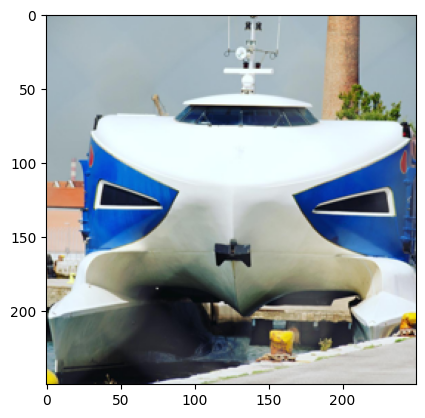

In [ ]:
# import matplotlib.pyplot as plt
# plt.imshow((X_image.iloc[2][0] * 255).astype('uint8'))

In [ ]:
# Assuming X_train_image is a Pandas Series or DataFrame containing image data as NumPy arrays:
#X_image = X_image.apply(lambda x: np.array(x))

In [ ]:
#type(X_image.iloc[0])

numpy.ndarray

In [ ]:
#y.shape

(1000,)

#START HERE

In [5]:
new_X_image = []
for row in X_image:
    for image in row:
        new_X_image.append(image)
new_X_image[0]
X_image = [np.array(img).astype(np.float32) for img in new_X_image]

In [6]:
resized_X_image = []
for img in X_image:
    if img.shape != (250, 250, 3):
        resized_img = np.resize(img, (250, 250, 3))
        resized_X_image.append(resized_img)
    else:
        resized_X_image.append(img)
X_image = np.array(resized_X_image)

In [7]:
print(X_image.shape)
print(X_image[0].shape)

(1000, 250, 250, 3)
(250, 250, 3)


In [8]:
y = y.replace({'damage': 1, 'non-damage': 0})

<ipython-input-8-29e6a47d55c9>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'damage': 1, 'non-damage': 0})


In [9]:
X_train_image, X_test_image, X_train_text, X_test_text, y_train, y_test = train_test_split(X_image, X_text, y, test_size=0.2, random_state=42)


In [ ]:
# def create_cnn_model():
#     base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
#     base_model.trainable = False  # Freeze the pre-trained layers
#     model = models.Sequential([
#         base_model,
#         layers.GlobalAveragePooling2D(),  # Reduce the spatial dimensions
#         layers.Dense(100, activation='relu'),
#         layers.Dense(50, activation='relu'),
#         layers.Dense(1, activation='sigmoid')
#     ])
#     return model



In [ ]:
# cnn_model.fit(X_train_image, y_train, epochs=10, batch_size=32)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 237s 9s/step - accuracy: 0.5397 - loss: 0.6972
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 255s 9s/step - accuracy: 0.5301 - loss: 0.6813
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 226s 9s/step - accuracy: 0.5694 - loss: 0.6717
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 257s 9s/step - accuracy: 0.5378 - loss: 0.6583
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 217s 9s/step - accuracy: 0.5743 - loss: 0.6476
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 265s 9s/step - accuracy: 0.6370 - loss: 0.6378
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 261s 9s/step - accuracy: 0.5526 - loss: 0.6746
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 268s 9s/step - accuracy: 0.6534 - loss: 0.6267
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 258s 9s/step - accuracy: 0.6527 - loss: 0.6254
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 259s 9s/step - accuracy: 0.6517 - loss: 0.6176


In [12]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# model = Sequential()

# # Add convolutional layers
# model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(250, 250, 3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())

# # Add fully connected layers
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))  # Optional dropout for regularization

# # Output layer (assuming classification)
# model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 248, 248, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 124, 124, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 119072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       7,620,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,625,825 (29.09 MB)

 Trainable params: 7,625,825 (29.09 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# history = model.fit(X_train_image,
#                     y_train,
#                     epochs=10,
#                     batch_size=32,
#                     )

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4290 - loss: 3.2004
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5212 - loss: 0.6896
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5596 - loss: 0.6695
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6666 - loss: 0.6695
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6834 - loss: 0.6209
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7391 - loss: 0.5757
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.7094 - loss: 0.5294
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7811 - loss: 0.4753
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8523 - loss: 0.3576
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9150 - loss: 0.2480


In [14]:
# model.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - accuracy: 0.6943 - loss: 0.6406


[0.6217878460884094, 0.6949999928474426]

In [15]:
# model_02 = Sequential()

# # Add convolutional layers
# model_02.add(Conv2D(64, (3, 3), activation='relu', input_shape=(250, 250, 3)))
# model_02.add(MaxPooling2D(pool_size=(2, 2)))

# model_02.add(Conv2D(128, (3, 3), activation='relu'))
# model_02.add(MaxPooling2D(pool_size=(2, 2)))

# model_02.add(Flatten())

# # Add fully connected layers
# model_02.add(Dense(64, activation='relu'))
# model_02.add(Dropout(0.3))  # Optional dropout for regularization

# # Output layer (assuming classification)
# model_02.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification

# # Compile the model
# model_02.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model_02.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 248, 248, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 124, 124, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 122, 122, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 61, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 476288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │      30,482,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,558,209 (116.57 MB)

 Trainable params: 30,558,209 (116.57 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# history_02 = model_02.fit(X_train_image,
#                     y_train,
#                     epochs=10,
#                     batch_size=32,
#                     )

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 226s 9s/step - accuracy: 0.4809 - loss: 4.7135
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 222s 9s/step - accuracy: 0.5228 - loss: 0.6782
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 264s 9s/step - accuracy: 0.6412 - loss: 0.6285
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 222s 9s/step - accuracy: 0.8242 - loss: 0.4344
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 222s 9s/step - accuracy: 0.8998 - loss: 0.2884
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 263s 9s/step - accuracy: 0.9396 - loss: 0.1394
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 262s 9s/step - accuracy: 0.9815 - loss: 0.0918
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 265s 9s/step - accuracy: 0.9898 - loss: 0.0554
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 259s 9s/step - accuracy: 0.9821 - loss: 0.0562
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 260s 9s/step - accuracy: 0.9951 - loss: 0.0285


In [17]:
# model_02.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5802 - loss: 1.7019


[1.5989699363708496, 0.5899999737739563]

Used Rasha's code from her file posted in Slack/Canvas.

I adjusted a few things.

I changed the Dense layer from 2 to 1.

I increased the Dropout from .3 to .5.

Increased L2 regularization from .01 to .02.

Added learning rate scheduler.

In [14]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import regularizers
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import ReduceLROnPlateau

# # Data augmentation
# datagen_03 = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest')

# # Fit the generator on your training data
# datagen_03.fit(X_train_image)

# # Learning Rate Scheduler
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# # Model definition with changes
# model_03 = Sequential()

# model_03.add(Conv2D(32, (3, 3), input_shape=(250, 250, 3)))
# model_03.add(LeakyReLU(alpha=0.1))
# model_03.add(MaxPooling2D(pool_size=(2, 2)))
# model_03.add(Dropout(0.5))  # Increased dropout

# model_03.add(Conv2D(64, (3, 3), input_shape=(250, 250, 3)))
# model_03.add(LeakyReLU(alpha=0.1))
# model_03.add(MaxPooling2D(pool_size=(2, 2)))
# model_03.add(Dropout(0.5))  # Increased dropout

# model_03.add(Conv2D(128, (3, 3), input_shape=(250, 250, 3)))
# model_03.add(LeakyReLU(alpha=0.1))
# model_03.add(MaxPooling2D(pool_size=(2, 2)))
# model_03.add(Dropout(0.5))  # Increased dropout

# model_03.add(Flatten())
# model_03.add(Dense(128, kernel_regularizer=regularizers.l2(0.02)))  # Adjusted L2
# model_03.add(LeakyReLU(alpha=0.1))
# model_03.add(Dropout(0.5))  # Increased dropout
# model_03.add(Dense(1, activation='sigmoid'))

# # Add generator to the training model
# # model_03.fit(datagen_03.flow(X_train_image, y_train, batch_size=32), epochs=10, validation_data=(X_image, y))

# # Compile the model with a lower learning rate
# optimizer_03 = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Reduced learning rate
# model_03.compile(optimizer=optimizer_03, loss='binary_crossentropy', metrics=['accuracy']) # Compile model_03 instead of model

# # Add generator to the training model
# model_03.fit(datagen_03.flow(X_train_image, y_train, batch_size=32), epochs=10, validation_data=(X_image, y))

# # Add scheduler to training model
# model_03.fit(X_train_image, y_train, epochs=10, callbacks=[lr_scheduler], validation_data=(X_image, y))

# # Compile the model with a lower learning rate
# optimizer_03 = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Reduced learning rate
# model.compile(optimizer=optimizer_03, loss='binary_crossentropy', metrics=['accuracy'])

# # Add scheduler to training model
# model_03.fit(X_train_image,
#             np.array(y_train),  # Convert y_train to NumPy array
#             epochs=10,
#             callbacks=[lr_scheduler],
#             validation_data=(X_image, np.array(y)))  # Convert y to NumPy array

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 183s 7s/step - accuracy: 0.5214 - loss: 5.8206 - val_accuracy: 0.5160 - val_loss: 4.7123
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 196s 7s/step - accuracy: 0.5062 - loss: 4.4748 - val_accuracy: 0.5170 - val_loss: 3.7466
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 174s 7s/step - accuracy: 0.5098 - loss: 3.5658 - val_accuracy: 0.5300 - val_loss: 3.0612
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 180s 7s/step - accuracy: 0.5065 - loss: 2.9396 - val_accuracy: 0.5480 - val_loss: 2.5750
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 202s 7s/step - accuracy: 0.5689 - loss: 2.4668 - val_accuracy: 0.6100 - val_loss: 2.2196
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 206s 7s/step - accuracy: 0.5191 - loss: 2.1431 - val_accuracy: 0.5650 - val_loss: 1.9501
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 184s 7s/step - accuracy: 0.5468 - loss: 1.8897 - val_accuracy: 0.5020 - val_loss: 1.7422
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 198s 7s/step - accuracy: 0.5236 - loss: 1.7015 - val_accuracy: 0.5500 - val_loss: 1.

ValueError: Cannot take the length of shape with unknown rank.

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import regularizers
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# # Data augmentation
# datagen_04 = ImageDataGenerator(
#     rotation_range=30, # Increased rotation
#     width_shift_range=0.3, # Increased width shift
#     height_shift_range=0.3, # Increased height shift
#     shear_range=0.3, # Increased shear
#     zoom_range=0.3, # Increased zoom
#     horizontal_flip=True,
#     brightness_range=[0.8, 1.2],  # Added brightness variation
#     fill_mode='nearest')


# # Fit the generator on your training data
# datagen_04.fit(X_train_image)

# # Learning Rate Scheduler
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# # Model definition with changes
# model_04 = Sequential()

# model_04.add(Conv2D(32, (3, 3), input_shape=(250, 250, 3)))
# model_04.add(LeakyReLU(alpha=0.1))
# model_04.add(MaxPooling2D(pool_size=(2, 2)))
# model_04.add(Dropout(0.5))  # Increased dropout

# model_04.add(Conv2D(64, (3, 3), input_shape=(250, 250, 3)))
# model_04.add(LeakyReLU(alpha=0.1))
# model_04.add(MaxPooling2D(pool_size=(2, 2)))
# model_04.add(Dropout(0.5))  # Increased dropout

# model_04.add(Conv2D(128, (3, 3), input_shape=(250, 250, 3)))
# model_04.add(LeakyReLU(alpha=0.1))
# model_04.add(MaxPooling2D(pool_size=(2, 2)))
# model_04.add(Dropout(0.5))  # Increased dropout

# model_04.add(Flatten())
# model_04.add(Dense(128, kernel_regularizer=regularizers.l2(0.02)))  # Adjusted L2
# model_04.add(LeakyReLU(alpha=0.1))
# model_04.add(Dropout(0.5))  # Increased dropout
# model_04.add(Dense(1, activation='sigmoid'))


# # Compile the model with a lower learning rate
# optimizer_03 = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Reduced learning rate
# model_03.compile(optimizer=optimizer_03, loss='binary_crossentropy', metrics=['accuracy']) # Compile model_03 instead of model

# # Add generator to the training model
# model_03.fit(datagen_03.flow(X_train_image, y_train, batch_size=32), epochs=10, validation_data=(X_image, y))

# # Add scheduler to training model
# model_03.fit(X_train_image, y_train, epochs=10, callbacks=[lr_scheduler], validation_data=(X_image, y))

# # Compile the model with a lower learning rate
# optimizer_03 = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Reduced learning rate
# model.compile(optimizer=optimizer_03, loss='binary_crossentropy', metrics=['accuracy'])

# # Add scheduler to training model
# model_03.fit(X_train_image,
#             np.array(y_train),  # Convert y_train to NumPy array
#             epochs=10,
#             callbacks=[lr_scheduler],
#             validation_data=(X_image, np.array(y)))  # Convert y to NumPy array

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import numpy as np

# More aggressive data augmentation
datagen_05 = ImageDataGenerator(
    rotation_range=30,  # Increased rotation
    width_shift_range=0.3,  # Increased width shift
    height_shift_range=0.3,  # Increased height shift
    shear_range=0.3,  # Increased shear
    zoom_range=0.3,  # Increased zoom
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Added brightness variation
    fill_mode='nearest')

datagen_05.fit(X_train_image)

# Model definition with changes
model_05 = Sequential()

model_05.add(Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)))
model_05.add(BatchNormalization())  # Added Batch Normalization
model_05.add(MaxPooling2D(pool_size=(2, 2)))
model_05.add(Dropout(0.4))  # Adjusted dropout

model_05.add(Conv2D(64, (3, 3), activation='relu'))
model_05.add(BatchNormalization())  # Added Batch Normalization
model_05.add(MaxPooling2D(pool_size=(2, 2)))
model_05.add(Dropout(0.4))  # Adjusted dropout

model_05.add(Conv2D(128, (3, 3), activation='relu'))
model_05.add(BatchNormalization())  # Added Batch Normalization
model_05.add(MaxPooling2D(pool_size=(2, 2)))
model_05.add(Dropout(0.4))  # Adjusted dropout

model_05.add(Flatten())
model_05.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Adjusted L2
model_05.add(Dropout(0.4))  # Adjusted dropout
model_05.add(Dense(1, activation='sigmoid'))

# Compile the model with a lower learning rate
optimizer_05 = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Reduced learning rate
model_05.compile(optimizer=optimizer_05, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
history_05 = model_05.fit(X_train_image,
                    y_train,
                    epochs=10,
                    batch_size=16,
                    )

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 260s 5s/step - accuracy: 0.6685 - loss: 2.5382
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 249s 5s/step - accuracy: 0.6830 - loss: 2.3589
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 252s 5s/step - accuracy: 0.7329 - loss: 2.1713
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 254s 5s/step - accuracy: 0.7594 - loss: 2.0302
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 256s 5s/step - accuracy: 0.7783 - loss: 1.8456
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 248s 5s/step - accuracy: 0.7975 - loss: 1.6898
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 265s 5s/step - accuracy: 0.8083 - loss: 1.5932
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 269s 5s/step - accuracy: 0.7977 - loss: 1.5168
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 255s 5s/step - accuracy: 0.7705 - loss: 1.4820
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - accuracy: 0.8409 - loss: 1.2848


In [14]:
model_05.evaluate(X_test_image, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5151 - loss: 10.4244


[10.330443382263184, 0.5199999809265137]

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
# from tensorflow.keras.models import Model

# # Define input shape for the images (e.g., 250x250x3 for RGB images)
# input_shape = (250, 250, 3)

# # Create the input layer
# image_input = Input(shape=input_shape)

# # Load the pretrained ResNet50 model with ImageNet weights, excluding the top fully connected layers
# resnet_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)

# # Add global average pooling to reduce the spatial dimensions
# x = GlobalAveragePooling2D()(resnet_model.output)

# # Add a fully connected layer (Dense) for further feature extraction
# x = Dense(256, activation='relu')(x)

# # Add the final output layer for classification (adjust the number of classes)
# num_classes = 1  # Replace with the number of classes in your problem
# output = Dense(num_classes, activation='softmax')(x)

# # Create the final model
# model_res = Model(inputs=image_input, outputs=output)

# # Compile the model
# model_res.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Model summary to check the architecture
# model_res.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 250, 250, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 256, 256, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 125, 125, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 125, 125, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 125, 125, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 127, 127, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 63, 63, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 63, 63, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 63, 63, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 63, 63, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 63, 63, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 63, 63, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 63, 63, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 63, 63, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 63, 63, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 24,059,393 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# history = model_res.fit(X_train_image,
#                     y_train,
#                     epochs=10,
#                     batch_size=32,
#                     )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(32, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 804s 30s/step - accuracy: 0.4881 - loss: 0.0000e+00
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 787s 30s/step - accuracy: 0.4798 - loss: 0.0000e+00
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 804s 30s/step - accuracy: 0.4749 - loss: 0.0000e+00
Epoch 4/10
10/25 ━━━━━━━━━━━━━━━━━━━━ 7:25 30s/step - accuracy: 0.5156 - loss: 0.0000e+00

In [ ]:
# def create_cnn_model():
#     base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(320, 320, 3))
#     base_model.trainable = False  # Freeze the pre-trained layers

#     model = models.Sequential([
#         base_model,
#         layers.GlobalAveragePooling2D(),  # Reduce the spatial dimensions
#         layers.Dense(100, activation='relu'),
#         layers.Dense(50, activation='relu'),
#     ])

#     return model

# cnn_model = create_cnn_model()

# # Extract features from images
# image_features = cnn_model.predict(images)
# print(image_features.shape)  # Should return (num_images, 256) for example

166/183 ━━━━━━━━━━━━━━━━━━━━ 3:50 14s/step

In [ ]:
# def create_cnn_model():
#     base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(320, 320, 3))
#     base_model.trainable = False  # Freeze the pre-trained layers

#     model = models.Sequential([
#         base_model,
#         layers.GlobalAveragePooling2D(),  # Reduce the spatial dimensions
#         layers.Dense(100, activation='relu'),
#         layers.Dense(50, activation='relu'),
#     ])

#     return model

# cnn_model = create_cnn_model()

# # Extract features from images
# image_features = cnn_model.predict(images)
# print(image_features.shape)  # Should return (num_images, 256) for example


# OR


# # CNN for image feature extraction
# def create_cnn_model(input_shape):
#     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
#     base_model.trainable = False  # Freeze the pre-trained layers

#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)  # Reduce dimensions
#     x = Dense(256, activation='relu')(x)
#     return base_model.input, x

# image_input_shape = (224, 224, 3)
# image_input, image_features = create_cnn_model(image_input_shape)

# # LSTM for text processing
# def create_lstm_model(vocab_size, embedding_dim, sequence_length):
#     text_input = Input(shape=(sequence_length,))
#     x = Embedding(vocab_size, embedding_dim, input_length=sequence_length)(text_input)
#     x = LSTM(128)(x)
#     return text_input, x

# vocab_size = len(tokenizer.word_index) + 1
# embedding_dim = 128
# sequence_length = max_sequence_length

# text_input, text_features = create_lstm_model(vocab_size, embedding_dim, sequence_length)

# # Combine image features and text features
# combined_features = Concatenate()([image_features, text_features])
# combined_output = Dense(128, activation='relu')(combined_features)
# final_output = Dense(1, activation='sigmoid')(combined_output)  # Binary classification

# # Build the complete model
# model = Model(inputs=[image_input, text_input], outputs=final_output)

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# # Model summary
# model.summary()


In [ ]:
# # Assuming `images` is a numpy array of image data
# # Assuming `texts` is a list of raw text corresponding to the images

# # Tokenize and pad the text data
# # tokenizer = Tokenizer(num_words=10000)  # Adjust vocabulary size as needed
# # tokenizer.fit_on_texts(texts)
# # sequences = tokenizer.texts_to_sequences(texts)
# # max_sequence_length = 100  # Define max sequence length
# # padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# # OR

# # Using GPT-2 Tokenizer
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# # Add a padding token to the tokenizer
# tokenizer.pad_token = tokenizer.eos_token

# def tokenize_texts(texts):
#     return tokenizer(texts, return_tensors='tf', padding=True, truncation=True, clean_up_tokenization_spaces=Fa

# # Tokenize the text data
# tokenized_texts = tokenize_texts(texts)

# # Example disaster reports (this could be loaded from your dataset)
# sample_reports = ["Flood in Texas causes widespread damage.",
#                   "Earthquake in Japan leads to massive destruction."]
# tokenized_reports = tokenize_texts(sample_reports)

# # Assuming `labels` is a numpy array containing the target labels for the task (e.g., 0 and 1 for binary classification)


Streaming output truncated to the last 5000 lines.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': True} not recognized.


In [ ]:
# # Split the data into training and test sets
# image_train, image_test, text_train, text_test, y_train, y_test = train_test_split(
#     images, padded_sequences, labels, test_size=0.2, random_state=42)

# print(f"Training set: {image_train.shape}, {text_train.shape}, {y_train.shape}")
# print(f"Test set: {image_test.shape}, {text_test.shape}, {y_test.shape}")

In [ ]:
# def create_lstm_model(image_feature_size, vocab_size, seq_length):
#     image_input = layers.Input(shape=(image_feature_size,))
#     text_input = layers.Input(shape=(seq_length,))

#     # Combine Image and Text features
#     x = layers.Concatenate()([image_input, text_input])
#     x = layers.Embedding(vocab_size, 256)(x)
#     x = layers.LSTM(256, return_sequences=True)(x)
#     x = layers.Dense(vocab_size, activation='softmax')(x)

#     model = models.Model(inputs=[image_input, text_input], outputs=x)
#     return model

# vocab_size = len(tokenizer)  # GPT tokenizer vocab size
# seq_length = tokenized_reports['input_ids'].shape[1]  # Max sequence length
# lstm_model = create_lstm_model(256, vocab_size, seq_length)

# lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# gpt2_model = TFGPT2LMHeadModel.from_pretrained('gpt2')

# # Fine-tune GPT-2 model
# def fine_tune_gpt2(image_features, texts, tokenizer):
#     inputs = tokenizer(texts, return_tensors="tf", padding=True, truncation=True)
#     outputs = gpt2_model(inputs['input_ids'], labels=inputs['input_ids'])
#     loss = outputs.loss
#     logits = outputs.logits

#     # Train your model on this loss
#     return loss

# # Example training loop
# for epoch in range(10):
#     loss = fine_tune_gpt2(image_features, sample_reports, tokenizer)
#     print(f"Epoch {epoch+1}, Loss: {loss}")


In [ ]:
# # Save the CNN + LSTM model or GPT-2 based model
# lstm_model.save("disaster_report_model.h5")

# # For GPT-2 (Hugging Face)
# gpt2_model.save_pretrained("disaster_gpt2_model")
# tokenizer.save_pretrained("disaster_gpt2_model_tokenizer")


# Creating Web Application

In [ ]:
# from flask import Flask, request, jsonify
# import tensorflow as tf
# from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
# from PIL import Image
# import numpy as np

# # Load the saved LSTM or GPT model
# lstm_model = tf.keras.models.load_model('disaster_report_model.h5')

# # If using GPT-2
# gpt2_model = TFGPT2LMHeadModel.from_pretrained('disaster_gpt2_model')
# tokenizer = GPT2Tokenizer.from_pretrained('disaster_gpt2_model_tokenizer')

# app = Flask(__name__)

# # Image preprocessing function
# def preprocess_image(image, target_size=(224, 224)):
#     image = Image.open(image)
#     image = image.resize(target_size)
#     image = np.array(image) / 255.0
#     image = np.expand_dims(image, axis=0)  # Add batch dimension
#     return image

# # Report generation endpoint
# @app.route('/generate_report', methods=['POST'])
# def generate_report():
#     file = request.files['image']

#     # Preprocess the input image
#     image = preprocess_image(file)

#     # Extract features from the image using CNN
#     image_features = lstm_model.predict(image)  # You may want to extract features only

#     # Use the LSTM or GPT model to generate a report
#     # If LSTM:
#     # generated_report = lstm_model.predict(image_features)

#     # If GPT-2:
#     input_text = tokenizer.decode(image_features[0])  # Convert image features to text for GPT-2
#     input_ids = tokenizer.encode(input_text, return_tensors="tf")
#     generated_report = gpt2_model.generate(input_ids, max_length=100, num_return_sequences=1)

#     report = tokenizer.decode(generated_report[0], skip_special_tokens=True)

#     return jsonify({"report": report})

# if __name__ == '__main__':
#     app.run(debug=True)


In [ ]:
# python app.py


In [ ]:
# curl -X POST -F "image=@/path/to/disaster_image.jpg" http://127.0.0.1:5000/generate_report


In [ ]:
# pip freeze > requirements.txt


In [ ]:
# web: python app.py


In [ ]:
# git init
# heroku create
# git add .
# git commit -m "First commit"
# git push heroku master
